imports
------------

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import matplotlib.pyplot as plt
import seaborn as sns

import torchtext.data as data
from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc

from gensim.models import Word2Vec


In [2]:
from gensim.utils import simple_preprocess
import numpy as np

functions
-----------

In [3]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()  

    for batch in iterator:
        optimizer.zero_grad() 
        predictions = model(batch.text).squeeze(1) 

        loss = criterion(predictions, batch.label) 
        acc = binary_accuracy(predictions, batch.label)
        
        
        loss.backward() 
        optimizer.step() 

        epoch_loss += loss.item() 
        epoch_acc += acc.item() 

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()  

    with torch.no_grad(): 
        for batch in iterator:
            predictions = model(batch.text).squeeze(1) 
            loss = criterion(predictions, batch.label) 
            acc = binary_accuracy(predictions, batch.label)  

            epoch_loss += loss.item() 
            epoch_acc += acc.item() 

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def count_metrics(model, iterator):
    model.eval()  
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(iterator):
            preds = model(batch.text).squeeze(1)
            all_preds.extend(preds.cpu())
            all_labels.extend(batch.label.cpu())

    all_preds = torch.tensor(all_preds)
    y_pred_binary = torch.round(torch.sigmoid(all_preds)).numpy()
    y_true = torch.tensor(all_labels).numpy()

    accuracy = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, all_preds.numpy())

    print(f"Accuracy: {accuracy:.4f}\nF1 Score: {f1:.4f}\nROC AUC: {roc_auc:.4f}")
    
    fpr, tpr, _ = roc_curve(y_true, all_preds.cpu().numpy())
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    sns.lineplot(x=fpr, y=tpr, color='darkorange', lw=2, label=f'area = {roc_auc:.2f}')
    sns.lineplot(x=[0, 1], y=[0, 1], color='red', lw=2, linestyle='--')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    


    
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', marker='o', color='blue')
    plt.plot(val_losses, label='Validation Loss', marker='x', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', marker='o', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', marker='x', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

preparation
-------------

In [4]:
platform = 'PC'
#platform = 'COLLAB'

print(f'Code is running on {platform}')

Code is running on PC


In [5]:
if platform == 'PC':
    df = pd.read_csv('FakeNewsNet.csv', usecols=['title','news_url','source_domain','real'])
    device = torch.device('cpu')
elif platform == 'COLLAB':
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_parquet('/content/drive/MyDrive/mla/FakeNewsNet.csv', usecols=['title','news_url','source_domain','real'])
    device = torch.device('cuda')
else:
    print('Choose the platform')

In [6]:
df.isna().sum()

title              0
news_url         330
source_domain    330
real               0
dtype: int64

In [7]:
df.dropna(inplace=True)

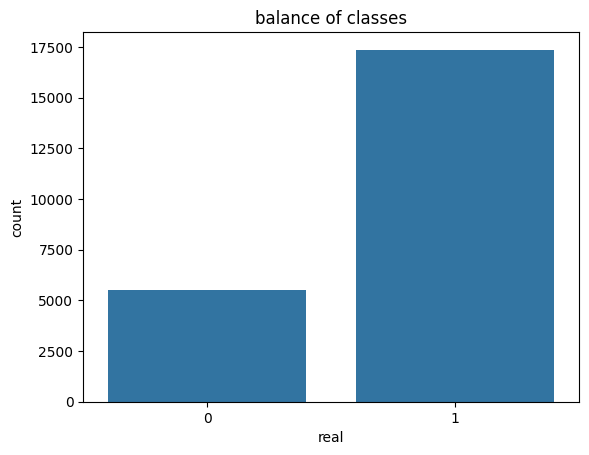

In [8]:
sns.countplot(x='real', data=df)
plt.title('balance of classes')
plt.show()

In [9]:
df['text'] = df['title'] + ' ' + df['news_url'] + ' ' + df['source_domain']

In [10]:
df = df[['text', 'real']]

In [11]:
TEXT = data.Field(sequential=True, tokenize='spacy', lower=True, tokenizer_language='en_core_web_sm')
LABEL = data.LabelField(dtype=torch.float)
SEED = 42
BATCH_SIZE = 30


In [12]:
examples = []
for index, row in df.iterrows():
    text = row['text']
    label = row['real']
    examples.append(data.Example.fromlist([text, label], fields=[('text', TEXT), ('label', LABEL)]))

In [13]:
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

In [14]:
random.seed(SEED)
train_data, test_data = dataset.split(split_ratio=0.7, random_state=random.seed(SEED), stratified='label')

In [15]:
# построение словаря
max_size = 30000
TEXT.build_vocab(train_data, max_size=max_size)
LABEL.build_vocab(train_data)

In [16]:
vocab_size = len(TEXT.vocab)
print("Количество элементов в словаре TEXT.vocab:", vocab_size)

Количество элементов в словаре TEXT.vocab: 30002


In [17]:
# Создаём итератор
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    shuffle=True,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text))

word2vec
--------------

In [18]:
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 100
W2V_MIN_COUNT = 2

In [19]:
# WORD2VEC
'''df['text_processed'] = df['text'].apply(lambda x: simple_preprocess(x))


w2v_model = Word2Vec(vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT)
w2v_model.build_vocab(df['text_processed'])
w2v_model.train(df['text_processed'], total_examples=len(df['text_processed']), epochs=W2V_EPOCH)
w2v_model.save("model.w2v")'''

'df[\'text_processed\'] = df[\'text\'].apply(lambda x: simple_preprocess(x))\n\n\nw2v_model = Word2Vec(vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT)\nw2v_model.build_vocab(df[\'text_processed\'])\nw2v_model.train(df[\'text_processed\'], total_examples=len(df[\'text_processed\']), epochs=W2V_EPOCH)\nw2v_model.save("model.w2v")'

In [20]:
w2v_model = Word2Vec.load("model.w2v")

In [21]:
word2vec_vectors = []

vocab_stoi = TEXT.vocab.stoi

for token in vocab_stoi:
    if token in w2v_model.wv.key_to_index:
        vector = w2v_model.wv.get_vector(token).copy() 
        word2vec_vectors.append(torch.FloatTensor(vector))
    else:
        vector = torch.zeros(W2V_SIZE)
    word2vec_vectors.append(torch.FloatTensor(vector))

TEXT.vocab.set_vectors(vocab_stoi, word2vec_vectors, W2V_SIZE)

In [22]:
embedding_matrix = np.array(word2vec_vectors)
pd.DataFrame(embedding_matrix)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.255539,-0.279281,-1.055118,1.333506,-0.092123,-2.727789,-0.799396,0.538492,0.226803,0.710867,...,0.163335,-0.087005,0.721163,-1.323718,-0.331854,-0.684103,0.100912,0.099794,-0.697892,1.002427
4,0.255539,-0.279281,-1.055118,1.333506,-0.092123,-2.727789,-0.799396,0.538492,0.226803,0.710867,...,0.163335,-0.087005,0.721163,-1.323718,-0.331854,-0.684103,0.100912,0.099794,-0.697892,1.002427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43068,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
43069,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
43070,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
43071,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
pre_trained_emb = torch.FloatTensor(TEXT.vocab.vectors)
embedding = nn.Embedding.from_pretrained(pre_trained_emb)

In [24]:
# Определяем параметры модели
EMBEDDING_DIM = W2V_SIZE
OUTPUT_DIM = 1

N_EPOCHS = 30

rnn
---------

In [26]:
class HW_Model_rnn(nn.Module):
    def __init__(self, embedding_dim, output_size, pretrained_embeddings):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.rnn = nn.RNN(embedding_dim, hidden_size=64, num_layers=2, bidirectional=True, dropout=0.5)
        self.fc_layers = nn.Sequential(
            nn.LazyLinear(64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(),

            nn.LazyLinear(32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Dropout(),

            nn.LazyLinear(output_size),
        )

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        output = self.fc_layers(hidden.squeeze(0)) 
        return output
    
model_rnn = HW_Model_rnn(EMBEDDING_DIM, OUTPUT_DIM, pre_trained_emb)
optimizer = optim.Adam(model_rnn.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

model_rnn = model_rnn.to(device)
criterion = criterion.to(device)
train_losses , val_losses, train_accuracies, val_accuracies = [],[],[],[]

c:\Users\ESC\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [27]:
best_val_loss = 1 #for early stopping
early_stopping_rate = 5 #for early stopping
early_stopping_rate_counter = 0 #for early stopping


for epoch in tqdm(range(N_EPOCHS)):
    train_loss, train_acc = train(model_rnn, train_iterator, optimizer, criterion)
    val_loss, val_acc = evaluate(model_rnn, test_iterator, criterion)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc*100:.2f}%')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

#Early stopping

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_rate_counter = 0  
    else:
        early_stopping_rate_counter += 1  

    if early_stopping_rate_counter >= early_stopping_rate:
        print("Stopping early")
        break



  3%|▎         | 1/30 [00:19<09:23, 19.43s/it]

Epoch: 01, Train Loss: 0.719, Train Acc: 51.20%, Val Loss: 0.640, Val Acc: 70.89%


  7%|▋         | 2/30 [00:37<08:46, 18.81s/it]

Epoch: 02, Train Loss: 0.602, Train Acc: 69.05%, Val Loss: 0.572, Val Acc: 78.65%


 10%|█         | 3/30 [00:55<08:17, 18.43s/it]

Epoch: 03, Train Loss: 0.557, Train Acc: 74.60%, Val Loss: 0.533, Val Acc: 80.18%


 13%|█▎        | 4/30 [01:14<08:02, 18.55s/it]

Epoch: 04, Train Loss: 0.526, Train Acc: 76.83%, Val Loss: 0.514, Val Acc: 79.82%


 17%|█▋        | 5/30 [01:32<07:42, 18.49s/it]

Epoch: 05, Train Loss: 0.507, Train Acc: 77.90%, Val Loss: 0.490, Val Acc: 80.08%


 20%|██        | 6/30 [01:50<07:19, 18.33s/it]

Epoch: 06, Train Loss: 0.490, Train Acc: 79.18%, Val Loss: 0.493, Val Acc: 77.37%


 23%|██▎       | 7/30 [02:09<07:07, 18.57s/it]

Epoch: 07, Train Loss: 0.469, Train Acc: 80.25%, Val Loss: 0.474, Val Acc: 78.45%


 27%|██▋       | 8/30 [02:28<06:47, 18.53s/it]

Epoch: 08, Train Loss: 0.459, Train Acc: 80.44%, Val Loss: 0.464, Val Acc: 78.58%


 30%|███       | 9/30 [02:46<06:28, 18.50s/it]

Epoch: 09, Train Loss: 0.441, Train Acc: 81.54%, Val Loss: 0.460, Val Acc: 78.08%


 33%|███▎      | 10/30 [03:04<06:02, 18.10s/it]

Epoch: 10, Train Loss: 0.425, Train Acc: 81.91%, Val Loss: 0.449, Val Acc: 78.36%


 37%|███▋      | 11/30 [03:21<05:40, 17.90s/it]

Epoch: 11, Train Loss: 0.418, Train Acc: 82.63%, Val Loss: 0.437, Val Acc: 79.45%


 40%|████      | 12/30 [03:37<05:10, 17.27s/it]

Epoch: 12, Train Loss: 0.407, Train Acc: 83.12%, Val Loss: 0.418, Val Acc: 81.30%


 43%|████▎     | 13/30 [03:52<04:43, 16.70s/it]

Epoch: 13, Train Loss: 0.396, Train Acc: 83.57%, Val Loss: 0.428, Val Acc: 79.91%


 47%|████▋     | 14/30 [04:08<04:21, 16.32s/it]

Epoch: 14, Train Loss: 0.383, Train Acc: 83.84%, Val Loss: 0.420, Val Acc: 80.83%


 50%|█████     | 15/30 [04:23<04:00, 16.01s/it]

Epoch: 15, Train Loss: 0.376, Train Acc: 84.56%, Val Loss: 0.418, Val Acc: 80.92%


 53%|█████▎    | 16/30 [04:39<03:44, 16.01s/it]

Epoch: 16, Train Loss: 0.365, Train Acc: 84.91%, Val Loss: 0.431, Val Acc: 79.29%


 57%|█████▋    | 17/30 [04:54<03:25, 15.81s/it]

Epoch: 17, Train Loss: 0.362, Train Acc: 85.29%, Val Loss: 0.419, Val Acc: 80.83%


 60%|██████    | 18/30 [05:12<03:17, 16.49s/it]

Epoch: 18, Train Loss: 0.352, Train Acc: 85.40%, Val Loss: 0.429, Val Acc: 79.75%


 63%|██████▎   | 19/30 [05:31<03:09, 17.26s/it]

Epoch: 19, Train Loss: 0.343, Train Acc: 85.93%, Val Loss: 0.435, Val Acc: 79.61%


 63%|██████▎   | 19/30 [05:48<03:21, 18.33s/it]

Epoch: 20, Train Loss: 0.339, Train Acc: 85.84%, Val Loss: 0.428, Val Acc: 79.33%
Stopping early


100%|██████████| 229/229 [00:01<00:00, 211.17it/s]


Accuracy: 0.7939
F1 Score: 0.6050
ROC AUC: 0.8307


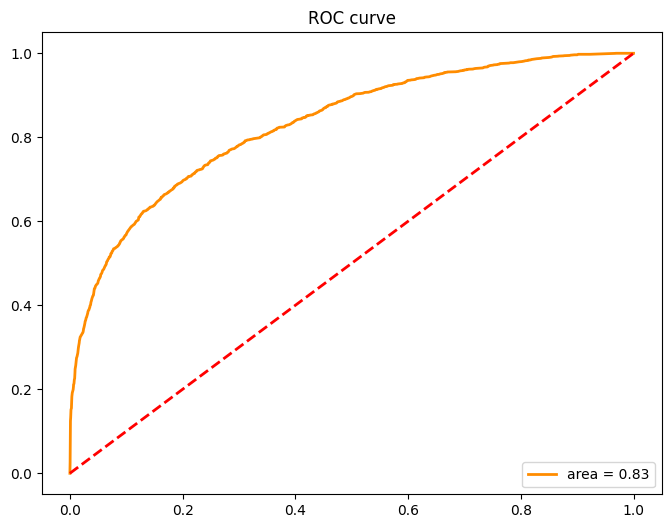

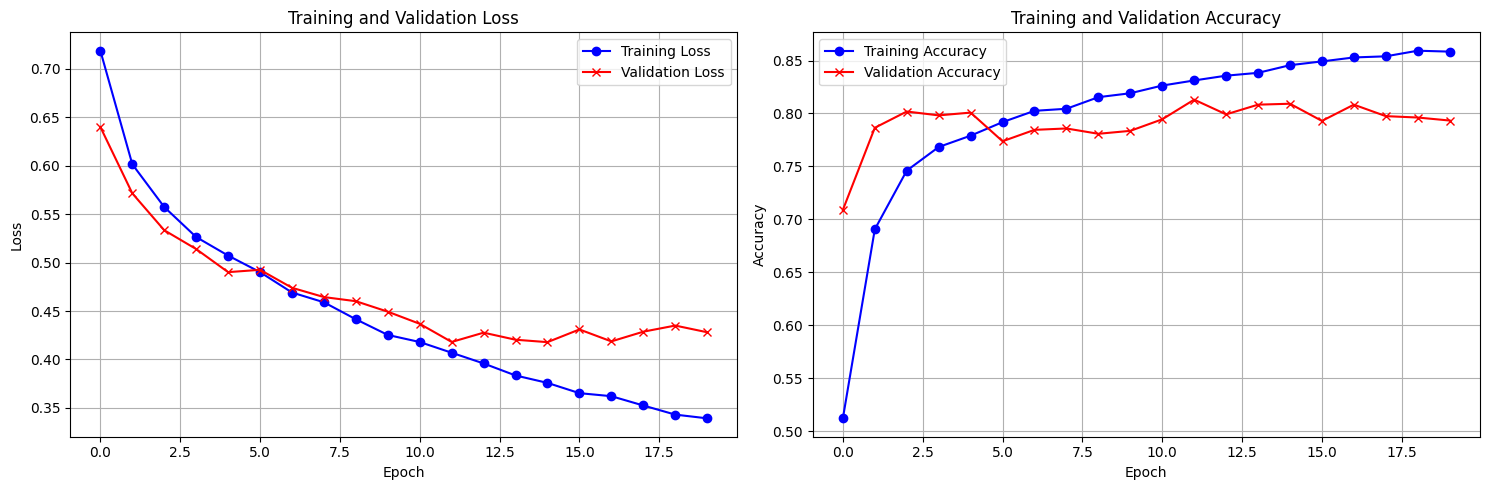

In [28]:
count_metrics(model_rnn, test_iterator)
plot_metrics(train_losses , val_losses, train_accuracies, val_accuracies)

LSTM
-------------

In [32]:
class HW_Model_LSTM(nn.Module):
    def __init__(self, embedding_dim, output_size, pretrained_embeddings):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.LSTM = nn.LSTM(embedding_dim, hidden_size=128, num_layers=2, bidirectional=True, dropout=0.3)
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.3),
            
            nn.LazyLinear(64),
            nn.ReLU(),
            
            nn.LazyLinear(output_size),
            nn.Sigmoid()
        )

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.LSTM(embedded)
        if self.LSTM.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]
        output = self.fc_layers(hidden.squeeze(0))
        return output

model_LSTM = HW_Model_LSTM(EMBEDDING_DIM, OUTPUT_DIM, pre_trained_emb)
optimizer = optim.Adam(model_LSTM.parameters(), lr=0.0001, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

model_LSTM = model_LSTM.to(device)
criterion = criterion.to(device)

train_losses_lstm , val_losses_lstm, train_accuracies_lstm, val_accuracies_lstm = [],[],[],[]

c:\Users\ESC\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [33]:
best_val_loss = 10 #for early stopping
early_stopping_rate = 5 #for early stopping
early_stopping_rate_counter = 0 #for early stopping


for epoch in tqdm(range(N_EPOCHS)):
    train_loss, train_acc = train(model_LSTM, train_iterator, optimizer, criterion)
    val_loss, val_acc = evaluate(model_LSTM, test_iterator, criterion)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc*100:.2f}%')

    train_losses_lstm.append(train_loss)
    train_accuracies_lstm.append(train_acc)
    val_losses_lstm.append(val_loss)
    val_accuracies_lstm.append(val_acc)

#Early stopping

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_rate_counter = 0
    else:
        early_stopping_rate_counter += 1

    if early_stopping_rate_counter >= early_stopping_rate:
        print("Stopping early")
        break



  3%|▎         | 1/30 [00:27<13:27, 27.85s/it]

Epoch: 01, Train Loss: 0.714, Train Acc: 24.02%, Val Loss: 0.693, Val Acc: 24.03%


  7%|▋         | 2/30 [00:57<13:36, 29.15s/it]

Epoch: 02, Train Loss: 0.693, Train Acc: 24.03%, Val Loss: 0.693, Val Acc: 24.03%


 10%|█         | 3/30 [01:27<13:15, 29.46s/it]

Epoch: 03, Train Loss: 0.693, Train Acc: 24.01%, Val Loss: 0.693, Val Acc: 24.03%


 13%|█▎        | 4/30 [01:58<12:59, 29.97s/it]

Epoch: 04, Train Loss: 0.693, Train Acc: 24.04%, Val Loss: 0.693, Val Acc: 24.03%


 17%|█▋        | 5/30 [02:29<12:37, 30.28s/it]

Epoch: 05, Train Loss: 0.692, Train Acc: 24.03%, Val Loss: 0.688, Val Acc: 24.03%


 20%|██        | 6/30 [03:00<12:10, 30.45s/it]

Epoch: 06, Train Loss: 0.680, Train Acc: 24.03%, Val Loss: 0.673, Val Acc: 24.03%


 23%|██▎       | 7/30 [03:39<12:46, 33.31s/it]

Epoch: 07, Train Loss: 0.668, Train Acc: 24.02%, Val Loss: 0.672, Val Acc: 24.03%


 27%|██▋       | 8/30 [04:12<12:10, 33.21s/it]

Epoch: 08, Train Loss: 0.666, Train Acc: 24.08%, Val Loss: 0.672, Val Acc: 24.03%


 30%|███       | 9/30 [04:44<11:28, 32.79s/it]

Epoch: 09, Train Loss: 0.664, Train Acc: 24.95%, Val Loss: 0.671, Val Acc: 24.03%


 33%|███▎      | 10/30 [05:16<10:51, 32.59s/it]

Epoch: 10, Train Loss: 0.663, Train Acc: 25.30%, Val Loss: 0.671, Val Acc: 24.03%


 37%|███▋      | 11/30 [05:47<10:08, 32.02s/it]

Epoch: 11, Train Loss: 0.661, Train Acc: 32.87%, Val Loss: 0.671, Val Acc: 36.59%


 40%|████      | 12/30 [06:16<09:24, 31.36s/it]

Epoch: 12, Train Loss: 0.660, Train Acc: 52.04%, Val Loss: 0.671, Val Acc: 35.46%


 43%|████▎     | 13/30 [06:47<08:48, 31.08s/it]

Epoch: 13, Train Loss: 0.659, Train Acc: 32.46%, Val Loss: 0.675, Val Acc: 24.22%


 47%|████▋     | 14/30 [07:17<08:14, 30.92s/it]

Epoch: 14, Train Loss: 0.659, Train Acc: 29.89%, Val Loss: 0.670, Val Acc: 24.03%


 50%|█████     | 15/30 [07:48<07:42, 30.83s/it]

Epoch: 15, Train Loss: 0.658, Train Acc: 26.66%, Val Loss: 0.670, Val Acc: 26.80%


 53%|█████▎    | 16/30 [08:18<07:06, 30.44s/it]

Epoch: 16, Train Loss: 0.657, Train Acc: 32.56%, Val Loss: 0.672, Val Acc: 24.41%


 57%|█████▋    | 17/30 [08:48<06:36, 30.48s/it]

Epoch: 17, Train Loss: 0.656, Train Acc: 37.04%, Val Loss: 0.671, Val Acc: 54.99%


 60%|██████    | 18/30 [09:18<06:03, 30.29s/it]

Epoch: 18, Train Loss: 0.656, Train Acc: 48.96%, Val Loss: 0.671, Val Acc: 66.08%


 63%|██████▎   | 19/30 [09:48<05:32, 30.22s/it]

Epoch: 19, Train Loss: 0.656, Train Acc: 67.79%, Val Loss: 0.670, Val Acc: 74.95%


 67%|██████▋   | 20/30 [10:19<05:03, 30.34s/it]

Epoch: 20, Train Loss: 0.656, Train Acc: 66.92%, Val Loss: 0.669, Val Acc: 72.18%


 70%|███████   | 21/30 [10:49<04:33, 30.41s/it]

Epoch: 21, Train Loss: 0.655, Train Acc: 44.95%, Val Loss: 0.674, Val Acc: 32.71%


 73%|███████▎  | 22/30 [11:19<04:01, 30.23s/it]

Epoch: 22, Train Loss: 0.654, Train Acc: 29.87%, Val Loss: 0.670, Val Acc: 24.60%


 77%|███████▋  | 23/30 [11:51<03:36, 30.86s/it]

Epoch: 23, Train Loss: 0.653, Train Acc: 33.36%, Val Loss: 0.670, Val Acc: 39.65%


 80%|████████  | 24/30 [12:26<03:11, 31.88s/it]

Epoch: 24, Train Loss: 0.653, Train Acc: 51.13%, Val Loss: 0.671, Val Acc: 38.49%


 80%|████████  | 24/30 [12:57<03:14, 32.40s/it]

Epoch: 25, Train Loss: 0.653, Train Acc: 47.48%, Val Loss: 0.670, Val Acc: 59.96%
Stopping early


In [ ]:
'''Accuracy: 0.8348
F1 Score: 0.6536
ROC AUC: 0.8576'''

100%|██████████| 229/229 [00:01<00:00, 115.96it/s]


Accuracy: 0.5994
F1 Score: 0.4898
ROC AUC: 0.7756


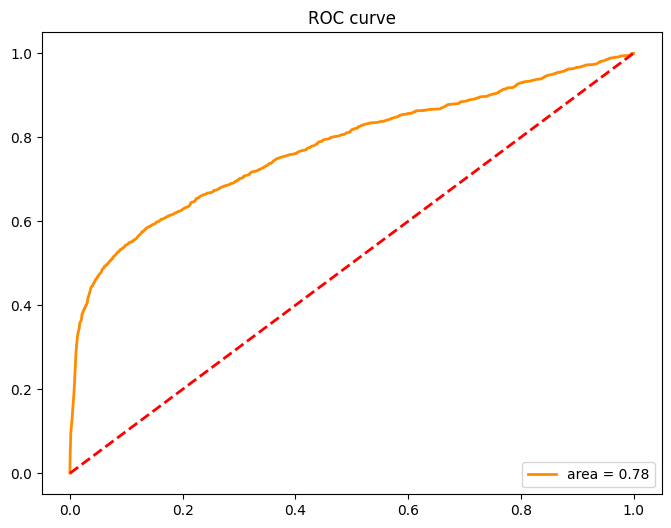

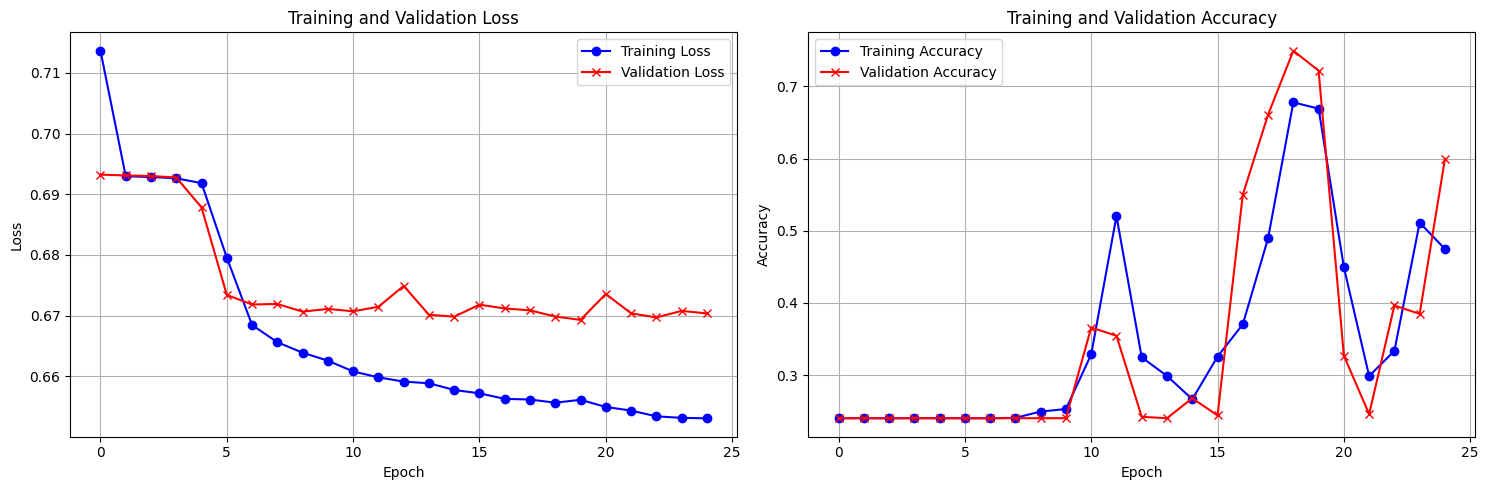

In [34]:
count_metrics(model_LSTM, test_iterator)
plot_metrics(train_losses_lstm , val_losses_lstm, train_accuracies_lstm, val_accuracies_lstm)

GRU
-------------

In [35]:
class HW_Model_GRU(nn.Module):
    def __init__(self, embedding_dim, output_size, pretrained_embeddings):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.GRU = nn.GRU(embedding_dim, hidden_size=128, bidirectional=True, num_layers=2, dropout=0.3)
        self.fc_layers = nn.Sequential(
            nn.LazyLinear(64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),
            nn.Dropout(),

            nn.LazyLinear(32),
            nn.LayerNorm(32),
            nn.LeakyReLU(),
            nn.Dropout(),

            nn.LazyLinear(output_size),
            nn.Sigmoid()
        )

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.GRU(embedded)
        if self.GRU.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]
        output = self.fc_layers(hidden.squeeze(0)) 
        return output
    
model_GRU = HW_Model_GRU(EMBEDDING_DIM, OUTPUT_DIM, pre_trained_emb)
optimizer = optim.Adam(model_GRU.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

model_GRU = model_GRU.to(device)
criterion = criterion.to(device)

train_losses_GRU , val_losses_GRU, train_accuracies_GRU, val_accuracies_GRU = [],[],[],[]

c:\Users\ESC\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [36]:
best_val_loss = 10 #for early stopping
early_stopping_rate = 5 #for early stopping
early_stopping_rate_counter = 0 #for early stopping


for epoch in tqdm(range(N_EPOCHS)):
    train_loss, train_acc = train(model_GRU, train_iterator, optimizer, criterion)
    val_loss, val_acc = evaluate(model_GRU, test_iterator, criterion)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc*100:.2f}%')

    train_losses_GRU.append(train_loss)
    train_accuracies_GRU.append(train_acc)
    val_losses_GRU.append(val_loss)
    val_accuracies_GRU.append(val_acc)

#Early stopping

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_rate_counter = 0
    else:
        early_stopping_rate_counter += 1

    if early_stopping_rate_counter >= early_stopping_rate:
        print("Stopping early")
        break



  3%|▎         | 1/30 [00:41<20:01, 41.44s/it]

Epoch: 01, Train Loss: 0.740, Train Acc: 24.02%, Val Loss: 0.707, Val Acc: 24.03%


  7%|▋         | 2/30 [01:30<21:19, 45.70s/it]

Epoch: 02, Train Loss: 0.711, Train Acc: 24.03%, Val Loss: 0.700, Val Acc: 24.03%


 10%|█         | 3/30 [02:18<21:08, 46.97s/it]

Epoch: 03, Train Loss: 0.704, Train Acc: 24.04%, Val Loss: 0.697, Val Acc: 24.03%


 13%|█▎        | 4/30 [03:09<20:58, 48.41s/it]

Epoch: 04, Train Loss: 0.701, Train Acc: 24.03%, Val Loss: 0.695, Val Acc: 24.03%


 17%|█▋        | 5/30 [04:13<22:36, 54.25s/it]

Epoch: 05, Train Loss: 0.698, Train Acc: 24.03%, Val Loss: 0.694, Val Acc: 24.03%


 20%|██        | 6/30 [05:13<22:28, 56.18s/it]

Epoch: 06, Train Loss: 0.697, Train Acc: 24.03%, Val Loss: 0.694, Val Acc: 24.03%


 23%|██▎       | 7/30 [06:15<22:15, 58.08s/it]

Epoch: 07, Train Loss: 0.696, Train Acc: 24.01%, Val Loss: 0.694, Val Acc: 24.03%


 27%|██▋       | 8/30 [07:28<23:01, 62.81s/it]

Epoch: 08, Train Loss: 0.695, Train Acc: 24.03%, Val Loss: 0.693, Val Acc: 24.03%


 30%|███       | 9/30 [08:45<23:28, 67.06s/it]

Epoch: 09, Train Loss: 0.695, Train Acc: 24.03%, Val Loss: 0.693, Val Acc: 24.03%


 33%|███▎      | 10/30 [09:52<22:23, 67.19s/it]

Epoch: 10, Train Loss: 0.694, Train Acc: 24.02%, Val Loss: 0.693, Val Acc: 24.03%


 37%|███▋      | 11/30 [10:53<20:42, 65.37s/it]

Epoch: 11, Train Loss: 0.694, Train Acc: 24.02%, Val Loss: 0.693, Val Acc: 24.03%


 40%|████      | 12/30 [11:53<19:06, 63.68s/it]

Epoch: 12, Train Loss: 0.694, Train Acc: 24.03%, Val Loss: 0.693, Val Acc: 24.03%


 43%|████▎     | 13/30 [12:55<17:53, 63.17s/it]

Epoch: 13, Train Loss: 0.694, Train Acc: 24.04%, Val Loss: 0.693, Val Acc: 24.03%


 47%|████▋     | 14/30 [14:00<17:00, 63.78s/it]

Epoch: 14, Train Loss: 0.693, Train Acc: 24.05%, Val Loss: 0.682, Val Acc: 24.03%


 50%|█████     | 15/30 [15:07<16:09, 64.65s/it]

Epoch: 15, Train Loss: 0.680, Train Acc: 24.22%, Val Loss: 0.678, Val Acc: 24.03%


 53%|█████▎    | 16/30 [16:10<14:57, 64.10s/it]

Epoch: 16, Train Loss: 0.674, Train Acc: 24.20%, Val Loss: 0.672, Val Acc: 24.03%


 57%|█████▋    | 17/30 [17:12<13:46, 63.60s/it]

Epoch: 17, Train Loss: 0.670, Train Acc: 24.34%, Val Loss: 0.670, Val Acc: 24.03%


 60%|██████    | 18/30 [18:16<12:42, 63.55s/it]

Epoch: 18, Train Loss: 0.667, Train Acc: 24.57%, Val Loss: 0.671, Val Acc: 24.03%


 63%|██████▎   | 19/30 [19:19<11:38, 63.54s/it]

Epoch: 19, Train Loss: 0.666, Train Acc: 24.80%, Val Loss: 0.671, Val Acc: 24.03%


 67%|██████▋   | 20/30 [20:17<10:17, 61.73s/it]

Epoch: 20, Train Loss: 0.665, Train Acc: 25.15%, Val Loss: 0.670, Val Acc: 24.03%


 70%|███████   | 21/30 [21:17<09:10, 61.17s/it]

Epoch: 21, Train Loss: 0.664, Train Acc: 25.44%, Val Loss: 0.669, Val Acc: 24.03%


 73%|███████▎  | 22/30 [22:17<08:06, 60.80s/it]

Epoch: 22, Train Loss: 0.663, Train Acc: 25.95%, Val Loss: 0.669, Val Acc: 24.03%


 77%|███████▋  | 23/30 [23:17<07:05, 60.85s/it]

Epoch: 23, Train Loss: 0.662, Train Acc: 26.76%, Val Loss: 0.668, Val Acc: 24.03%


 80%|████████  | 24/30 [24:17<06:02, 60.49s/it]

Epoch: 24, Train Loss: 0.661, Train Acc: 27.69%, Val Loss: 0.668, Val Acc: 24.03%


 83%|████████▎ | 25/30 [25:17<05:00, 60.17s/it]

Epoch: 25, Train Loss: 0.661, Train Acc: 28.20%, Val Loss: 0.667, Val Acc: 24.03%


 87%|████████▋ | 26/30 [26:15<03:58, 59.52s/it]

Epoch: 26, Train Loss: 0.659, Train Acc: 28.58%, Val Loss: 0.669, Val Acc: 24.03%


 90%|█████████ | 27/30 [27:20<03:03, 61.33s/it]

Epoch: 27, Train Loss: 0.659, Train Acc: 29.08%, Val Loss: 0.669, Val Acc: 24.03%


 93%|█████████▎| 28/30 [28:20<02:01, 60.76s/it]

Epoch: 28, Train Loss: 0.659, Train Acc: 30.27%, Val Loss: 0.669, Val Acc: 24.03%


 97%|█████████▋| 29/30 [29:12<00:58, 58.15s/it]

Epoch: 29, Train Loss: 0.657, Train Acc: 31.06%, Val Loss: 0.668, Val Acc: 24.03%


 97%|█████████▋| 29/30 [30:09<01:02, 62.40s/it]

Epoch: 30, Train Loss: 0.658, Train Acc: 31.99%, Val Loss: 0.668, Val Acc: 24.03%
Stopping early


100%|██████████| 229/229 [00:05<00:00, 39.02it/s]


Accuracy: 0.2404
F1 Score: 0.3876
ROC AUC: 0.7931


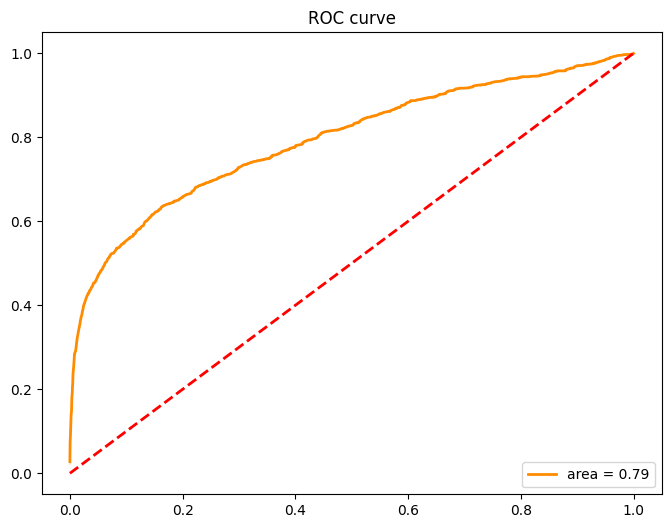

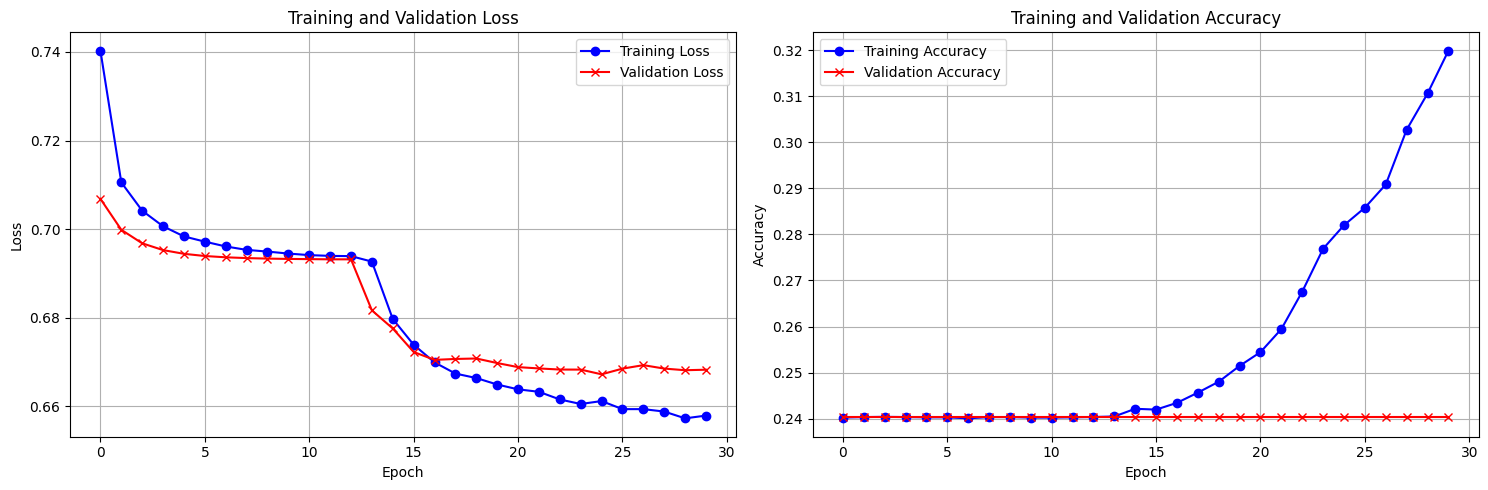

In [37]:
count_metrics(model_GRU, test_iterator)
plot_metrics(train_losses_GRU , val_losses_GRU, train_accuracies_GRU, val_accuracies_GRU)